In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import os
from tqdm.notebook import tqdm
from pathlib import Path
import shutil


from music_plots import *
import numpy as np

In [2]:
files = os.listdir('data/spectrograms')
tracks_df = load("data/tracks.csv")
genres_df = load("data/genres.csv")

In [3]:
track_ids = []
print(files)
for file in tqdm(files):
    pre, ext = os.path.splitext(file)
    track_ids.append(int(pre))

['98236.png', '18350.png', '93363.png', '98550.png', '46238.png', '75194.png', '68853.png', '97887.png', '38902.png', '98578.png', '14542.png', '55293.png', '37416.png', '27611.png', '67235.png', '55287.png', '67553.png', '27177.png', '90695.png', '97844.png', '70775.png', '14581.png', '72604.png', '61491.png', '26902.png', '81565.png', '15476.png', '75396.png', '87100.png', '39188.png', '18146.png', '63292.png', '53379.png', '96743.png', '34484.png', '94632.png', '59654.png', '11638.png', '14740.png', '13749.png', '61452.png', '60994.png', '75427.png', '44822.png', '69768.png', '71133.png', '75433.png', '63251.png', '60758.png', '64516.png', '39605.png', '20432.png', '24898.png', '59683.png', '91164.png', '43022.png', '98626.png', '11764.png', '52649.png', '45335.png', '59708.png', '41147.png', '18032.png', '11770.png', '91170.png', '36481.png', '91158.png', '12537.png', '59720.png', '54576.png', '94034.png', '16745.png', '93983.png', '62749.png', '63457.png', '64338.png', '38321.png'

  0%|          | 0/140 [00:00<?, ?it/s]

In [4]:
#tracks_df.columns = pd.MultiIndex.from_product([['track'],['id']])
filtered_tracks = tracks_df.xs('track', level=0, axis=1)['genre_top'].loc[track_ids]
filtered_tracks

track_id
98236     Instrumental
18350             Folk
93363       Electronic
98550          Hip-Hop
46238     Experimental
             ...      
6608           Hip-Hop
6387     International
6393     International
4235     International
1417              Rock
Name: genre_top, Length: 140, dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

Some tracks don't have a genre

In [5]:
filtered_tracks.isna().any()

False

Check all top level genres

In [6]:
filtered_tracks.unique()

['Instrumental', 'Folk', 'Electronic', 'Hip-Hop', 'Experimental', 'Pop', 'Rock', 'International']
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

In [7]:
filtered_tracks.loc[4037]

'Folk'

Generate directories

In [110]:
Path("dataset").mkdir(parents=True, exist_ok=True)

for genres in tqdm(filtered_tracks.unique()):
    Path("dataset/"+genres).mkdir(parents=True, exist_ok=True)

for track_id in tqdm(filtered_tracks.index):
    shutil.copyfile('data/spectrograms/' + str(track_id) + ".png", "dataset/" + filtered_tracks.loc[track_id] + "/" + str(track_id) + ".png")

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7847 [00:00<?, ?it/s]

In [9]:
image_size = (200, 600)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 140 files belonging to 8 classes.
Using 112 files for training.
Metal device set to: Apple M1 Pro
Found 140 files belonging to 8 classes.
Using 28 files for validation.


2022-06-16 11:44:52.204634: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-16 11:44:52.204774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


tf.Tensor([4 1 5 6 3 7 0 7 3 6 3 2 6 0 7 4 4 7 6 6 4 3 5 4 5 1 7 3 6 3 0 5], shape=(32,), dtype=int32)


2022-06-16 11:44:52.265927: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


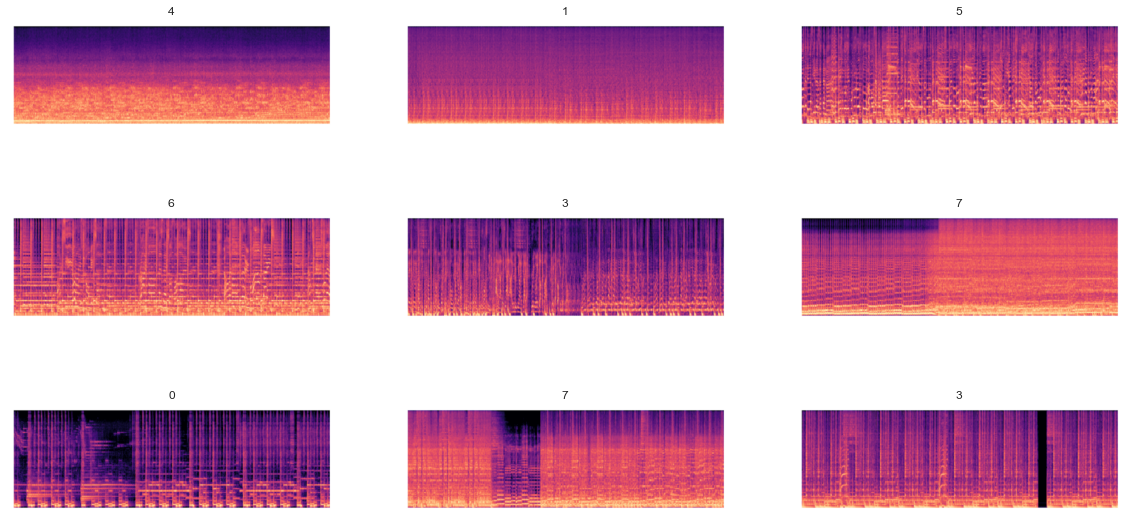

In [10]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    print(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [11]:
#with tf.device('/cpu:0'):
#    data_augmentation = keras.Sequential(
#        [
#            layers.RandomFlip("horizontal"),
#            layers.RandomRotation(0.1),
#        ]
#    )

In [12]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

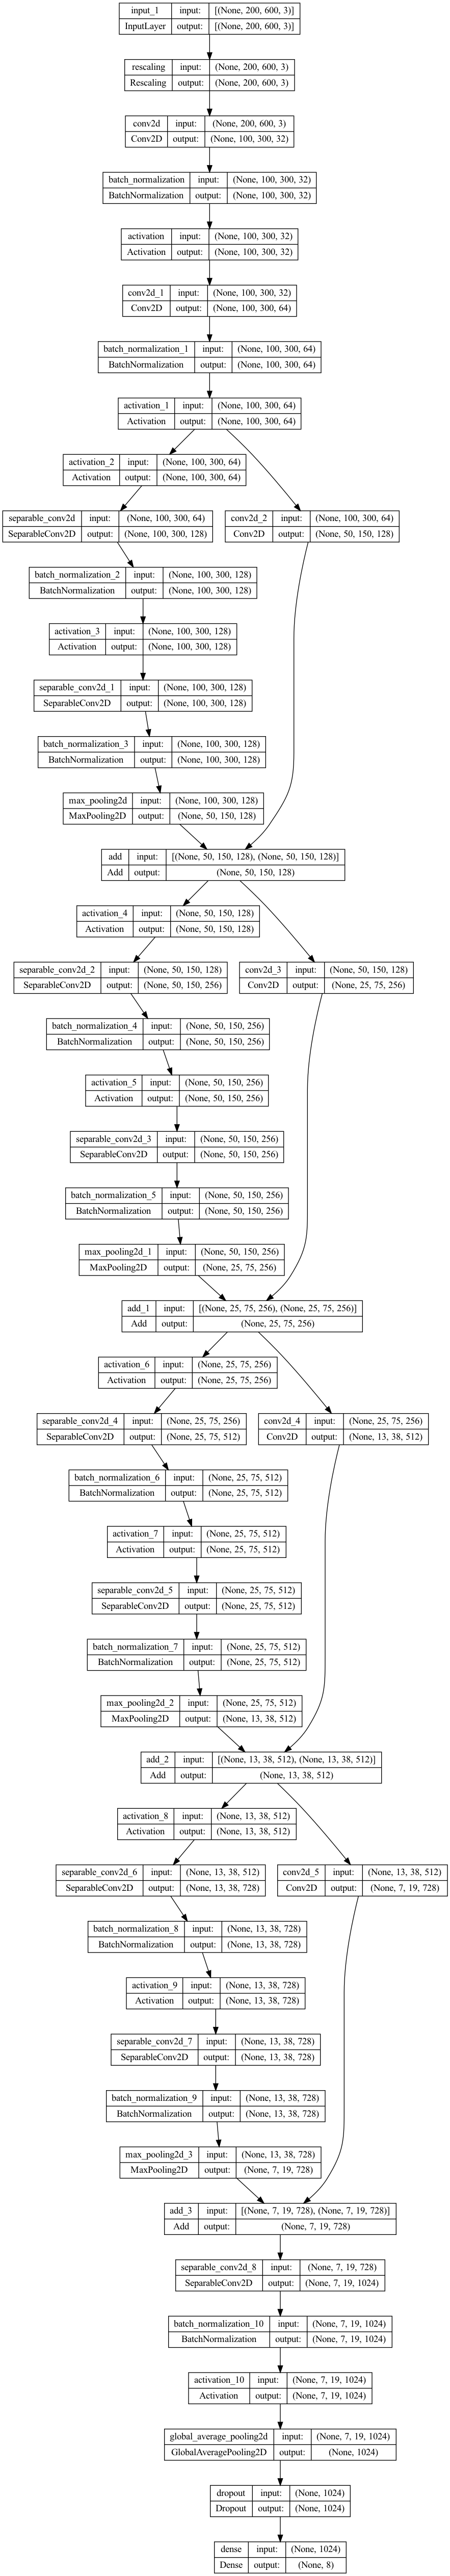

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = inputs

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=8)
keras.utils.plot_model(model, show_shapes=True)

In [14]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10


2022-06-16 11:44:54.418512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 2.1139 - accuracy: 0.1696

2022-06-16 11:44:58.672414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 6s 1s/step - loss: 2.1139 - accuracy: 0.1696 - val_loss: 2.0793 - val_accuracy: 0.0714
Epoch 2/10
4/4 [==============================] - 5s 1s/step - loss: 1.7533 - accuracy: 0.4107 - val_loss: 2.0820 - val_accuracy: 0.0714
Epoch 3/10
4/4 [==============================] - 4s 1s/step - loss: 1.6276 - accuracy: 0.3750 - val_loss: 2.0842 - val_accuracy: 0.0714
Epoch 4/10
4/4 [==============================] - 5s 1s/step - loss: 1.3276 - accuracy: 0.4286 - val_loss: 2.0864 - val_accuracy: 0.1429
Epoch 5/10
4/4 [==============================] - 5s 1s/step - loss: 1.2478 - accuracy: 0.5179 - val_loss: 2.0864 - val_accuracy: 0.1429
Epoch 6/10
4/4 [==============================] - 5s 1s/step - loss: 1.0650 - accuracy: 0.5982 - val_loss: 2.0906 - val_accuracy: 0.1429
Epoch 7/10
4/4 [==============================] - 5s 1s/step - loss: 0.9468 - accuracy: 0.6429 - val_loss: 2.0974 - val_accuracy: 0.1429
Epoch 8/10
4/4 [==============================] - 4s

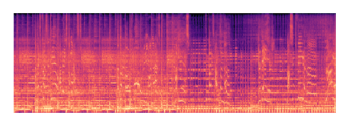

1/1 [==============================] - 0s 20ms/step


array([[0.1236999 , 0.1717123 , 0.11125528, 0.1087231 , 0.13292013,
        0.10009873, 0.10668603, 0.1449045 ]], dtype=float32)

In [20]:
def load_image_pr(img_path, show=False):

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(200, 600))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor


img_path = 'dataset/Rock/1417.png'    # dog

new_image = load_image_pr(img_path, show=True)
pred = model.predict(new_image)
pred
img = tf.keras.preprocessing.image.load_img(
    "dataset/Hip-Hop/6608.png", target_size=image_size
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
predictions

Eseguire da QUI

Second try


In [23]:
files = os.listdir('data/spectrograms')
track_ids = []
print(files)
for file in tqdm(files):
    pre, ext = os.path.splitext(file)
    track_ids.append(int(pre))

filtered_tracks = tracks_df.xs('track', level=0, axis=1)['genre_top'].loc[track_ids]
filtered_tracks

['73309.png', '32433.png', '127062.png', '131166.png', '14386.png', '66076.png', '30230.png', '67368.png', '143296.png', '73335.png', '122654.png', '122132.png', '71244.png', '43590.png', '126354.png', '25601.png', '71250.png', '124231.png', '38888.png', '132453.png', '126426.png', '75750.png', '55480.png', '117610.png', '129926.png', '112768.png', '115761.png', '12046.png', '129098.png', '12052.png', '113304.png', '115775.png', '99707.png', '133942.png', '58173.png', '19891.png', '75787.png', '80518.png', '45122.png', '118279.png', '134793.png', '51157.png', '10679.png', '116240.png', '42659.png', '81612.png', '62589.png', '96408.png', '116526.png', '122683.png', '28480.png', '21895.png', '30740.png', '109189.png', '118084.png', '13199.png', '127274.png', '108297.png', '72215.png', '132679.png', '70402.png', '93941.png', '76073.png', '133567.png', '17499.png', '144937.png', '123760.png', '133573.png', '137715.png', '43962.png', '11942.png', '122456.png', '65755.png', '141873.png', '73

  0%|          | 0/7847 [00:00<?, ?it/s]

track_id
73309             Rock
32433       Electronic
127062            Folk
131166            Rock
14386          Hip-Hop
              ...     
139537    Instrumental
83791             Rock
122671    Instrumental
67365              Pop
71507       Electronic
Name: genre_top, Length: 7847, dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

In [58]:
img_shape = (484, 174)
top_model_weights_path = 'bottleneck_fc_model.h5'

Path("dataset_2").mkdir(parents=True, exist_ok=True)
#Path("dataset_2/train").mkdir(parents=True, exist_ok=True)
#Path("dataset_2/test").mkdir(parents=True, exist_ok=True)
#Path("dataset_2/validation").mkdir(parents=True, exist_ok=True)

train_ds, validation_ds, test_ds = np.split(filtered_tracks, [int(.8*len(filtered_tracks)), int(.9*len(filtered_tracks))])

print(f"Training has {len(train_ds)}, Validation has {len(validation_ds)}, Testing has {len(test_ds)}")

Training has 6277, Validation has 785, Testing has 785


In [59]:
labels = filtered_tracks.unique()
print(f"Labels found are: {labels}")

"""
for genres in tqdm(filtered_tracks.unique()):
    Path("dataset_2/train/"+genres).mkdir(parents=True, exist_ok=True)
    Path("dataset_2/validation/"+genres).mkdir(parents=True, exist_ok=True)
    Path("dataset_2/test/"+genres).mkdir(parents=True, exist_ok=True)
"""
for track_id in tqdm(train_ds.index):
    #shutil.copyfile('data/spectrograms/' + str(track_id) + ".png", "dataset_2/train/" + filtered_tracks.loc[track_id] + "/" + str(track_id) + ".png")
    shutil.copyfile('data/spectrograms/' + str(track_id) + ".png", "dataset_2/train/" +  str(track_id) + ".png")
for track_id in tqdm(validation_ds.index):
    shutil.copyfile('data/spectrograms/' + str(track_id) + ".png", "dataset_2/validation/" + str(track_id) + ".png")

train_size = len(train_ds)
validation_size = len(validation_ds)
test_size = len(test_ds)

print(f"Traing size {train_size}, validation size {validation_size}, testing size {test_size}")

Labels found are: ['Rock', 'Electronic', 'Folk', 'Hip-Hop', 'Pop', 'Instrumental', 'Experimental', 'International']
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6277 [00:00<?, ?it/s]

  0%|          | 0/785 [00:00<?, ?it/s]

Traing size 6277, validation size 785, testing size 785


In [55]:
# loading up our datasets
train_data_dir = 'dataset_2/train'
validation_data_dir = 'dataset_2/validation'
test_data_dir = 'dataset_2/test'

# number of epochs to train top model
epochs = 7 #this has been changed after multiple model run
# batch size used by flow_from_directory and predict_generator
batch_size = 50

In [169]:
from keras.layers import *

def model(width, height, depth, classes, finalAct="softmax"):
    model = Sequential()

    model.add(Flatten(input_shape=(height, width, 3)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    return model

In [146]:
from keras_preprocessing.image import img_to_array

data = []
labels = []
training_images = os.listdir('dataset_2/train')
validation_images = os.listdir('dataset_2/validation')
for img in tqdm(training_images):
    image = tf.keras.preprocessing.image.load_img("dataset_2/train/" + img)
    image = img_to_array(image)
    data.append(image)

    pre, ext = os.path.splitext(img)
    labels.append(train_ds.loc[int(pre)])

validation_data = []
validation_labels = []
for img in tqdm(validation_images):
    image = tf.keras.preprocessing.image.load_img("dataset_2/validation/" + img)
    image = img_to_array(image)
    validation_data.append(image)

    pre, ext = os.path.splitext(img)
    validation_labels.append(validation_ds.loc[int(pre)])

  0%|          | 0/6277 [00:00<?, ?it/s]

  0%|          | 0/785 [00:00<?, ?it/s]

In [153]:
data = np.array(data, dtype="float") / 255.0
print(data.shape)
print(len(data))
labels = np.array(labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
	len(training_images), data.nbytes / (1024 * 1000.0)))

validation_data =  np.array(validation_data, dtype="float") / 255.0
validation_labels = np.array(validation_labels)


(6277, 174, 484, 3)
6277
[INFO] data matrix: 6277 images (12389.62MB)


In [170]:
model = model(
	width=484, height=174,
	depth=3, classes=8)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 252648)            0         
                                                                 
 dense_56 (Dense)            (None, 128)               32339072  
                                                                 
 dense_57 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 32,340,104
Trainable params: 32,340,104
Non-trainable params: 0
_________________________________________________________________
None


In [149]:
from sklearn.preprocessing import LabelBinarizer

print(len(data))
print(data)
print(len(labels))
encoder = LabelBinarizer()
transformed_labels = encoder.fit_transform(labels)
print(len(labels))
validation_labels = encoder.fit_transform(validation_labels)

6277
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]


 [[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...


In [187]:
history = model.fit(data, transformed_labels, validation_data=(validation_data, validation_labels), epochs=10, batch_size=64)

Epoch 1/10
99/99 [==============================] - 17s 170ms/step - loss: 2.0081 - accuracy: 0.1877 - val_loss: 1.8990 - val_accuracy: 0.2854
Epoch 2/10
99/99 [==============================] - 14s 138ms/step - loss: 1.9977 - accuracy: 0.1956 - val_loss: 1.8985 - val_accuracy: 0.3032
Epoch 3/10
99/99 [==============================] - 14s 140ms/step - loss: 1.9899 - accuracy: 0.2004 - val_loss: 1.8709 - val_accuracy: 0.2764
Epoch 4/10
99/99 [==============================] - 14s 143ms/step - loss: 1.9897 - accuracy: 0.1956 - val_loss: 1.8676 - val_accuracy: 0.2777
Epoch 5/10
99/99 [==============================] - 14s 137ms/step - loss: 1.9807 - accuracy: 0.1990 - val_loss: 1.8523 - val_accuracy: 0.3083
Epoch 6/10
99/99 [==============================] - 14s 140ms/step - loss: 1.9798 - accuracy: 0.2023 - val_loss: 1.8640 - val_accuracy: 0.2815
Epoch 7/10
99/99 [==============================] - 14s 145ms/step - loss: 1.9696 - accuracy: 0.2018 - val_loss: 1.8543 - val_accuracy: 0.3045

In [203]:
image = tf.keras.preprocessing.image.load_img("dataset/Rock/3840.png")
image = img_to_array(image)
grr = [image]
grr = np.array(grr, dtype="float") / 255.0
print(validation_labels[:1])
print(encoder.inverse_transform(validation_labels[:1]))
model.predict(grr)

[[0 0 0 0 0 0 0 1]]
['Rock']
1/1 [==============================] - 0s 9ms/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        5.2182375e-36, 0.0000000e+00, 2.3616610e-36, 1.0000000e+00]],
      dtype=float32)